# Make a Helmholtz solver

In [1]:
from matplotlib import pyplot as plt

from jaxdf.geometry import Domain
from jaxdf import operators as jops
from jaxdf.core import operator
from jax import numpy as jnp
import jax

The equation we want to simulate is

$$
\left(\nabla^2 - \frac{\omega^2}{c^2} \right)u = - i\omega S_M
$$

Furthermore, to enforce the Sommerfield radiation conditions, the components of the spatial differential operators are modified as [[1]](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf):

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

where

$$
\gamma_j = 1 + \frac{\sigma_j(x)}{k_0}, \qquad \sigma_j(x) = \begin{cases}
\frac{\sigma^*\|x_j - \Delta_{PML}\|^\alpha}{\Delta_{PML}}, & \|x\| > \Delta_{PML}\\
0, & \text{otherwise} \\
\end{cases}$$

Let's start by building up the $\sigma$ function

## $\sigma$ function

In [2]:
domain = Domain((256, 256), (1., 1.))
omega = 1.

In [3]:
from jaxdf.discretization import Coordinate
from jaxdf.core import Field

coordinate_discr = Coordinate(domain)
x = Field(coordinate_discr, params={}, name="x")

grid = coordinate_discr.get_field_on_grid()({})

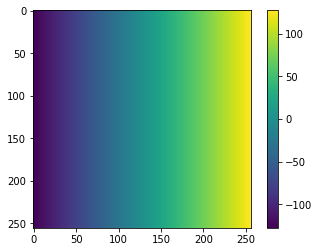

In [4]:
plt.imshow(grid[...,1])
plt.colorbar()

In [5]:
delta_pml = 110.

def pml_absorption_fun(x):
    abs_x = jnp.abs(x)
    return jnp.where(abs_x > delta_pml, (jnp.abs(abs_x-delta_pml)/(128. - delta_pml)), 0.)**2

def gamma(x):
    y = jops.elementwise(pml_absorption_fun)(x)
    return 1./(1 + 1j*y/omega)

In [6]:
outfield = operator()(gamma)(x=x)
global_params = outfield.get_global_params()

# Can use directly this on a GridBased discretization
pml_on_grid = outfield.get_field_on_grid(0)(global_params, {'x': {}})

# Or can use the PML function, if the downstream task requires it.
pml_f = lambda x: outfield.get_field(0)(global_params, {'x': {}}, x)

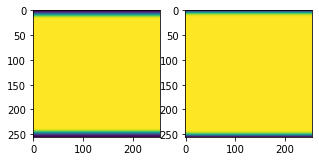

In [7]:
fig, ax = plt.subplots(1,2,figsize=(5,12))
ax[0].imshow(pml_on_grid[...,0].imag)
ax[1].imshow(pml_on_grid[...,0].real)

# Modified $\nabla^2$ operator

In [8]:
def laplacian(u, x):
    pml = gamma(x)
    grad_u = jops.gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = jops.diag_jacobian(mod_grad_u)*pml
    return jops.sum_over_dims(mod_diag_jacobian)

## Helmholtz operator

In [9]:
@operator()
def helmholtz(u, c, x):
    # Get the modified laplacian
    L = laplacian(u, x)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u
    
    return L + k

Let's make the operator concrete by specifying the discretizations

In [10]:
from jaxdf.discretization import FourierSeries

# Initialize discretizations
fourier_discr = FourierSeries(domain)

# Initialize parameters (we already have the PML parameters)
u_fourier_params, u = fourier_discr.empty_field(name='u')

src_fourier_params, src = fourier_discr.empty_field(name='src')
src_fourier_params = u_fourier_params.at[128, 40].set(1. + 0j)  # Source field, using Fourier discretization

c_fourier_params, c = fourier_discr.empty_field(name='c')
c_fourier_params = c_fourier_params + 1.                      # Uniform SoS of 1.
c_fourier_params = c_fourier_params.at[20:40,20:100].set(2.)
c_fourier_params = c_fourier_params.at[20:200,150:200].set(1.5)

x = Field(fourier_discr, params=pml_on_grid, name='pml')
x_params = grid

In [11]:
# Make the computational graph
Hu = helmholtz(u=u, c=c, x=x)
global_params = Hu.get_global_params()

def helm_func(u):
    return Hu.get_field_on_grid(0)(
        global_params,
        {"u":u, "c":c_fourier_params, "x":x_params}
    )

In [12]:
helm_func(u_fourier_params).shape

(256, 256, 1)

### Solve with GMRES

In [13]:
from jax.scipy.sparse.linalg import gmres
from functools import partial

sol, _ = gmres(helm_func, src_fourier_params, maxiter=1000)

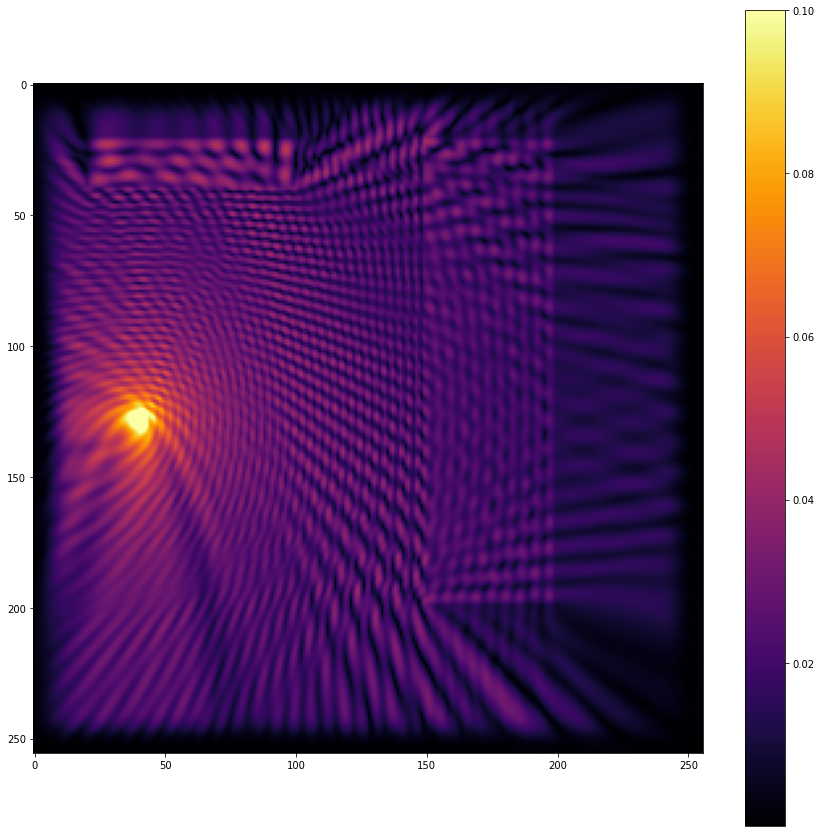

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(jnp.abs(sol), cmap="inferno", vmax=.1)
plt.colorbar()

## Make lens

In [15]:
def join_dicts(dict1, dict2):
    for k, v in dict2.items():
        if k in dict1:
            continue
        else:
            dict1[k] = v
    return dict1

@operator()
def total_variation(u):
    nabla_u = jops.gradient(u)    
    return jops.sum_over_dims(jops.elementwise(jnp.abs)(nabla_u))

TV = total_variation(u=u)
global_params = join_dicts(global_params, TV.get_global_params())
tv_on_grid = TV.get_field_on_grid(0)

tv_fun = lambda u: tv_on_grid(global_params, {"u": u})

In [203]:
from jax import random

seed = random.PRNGKey(32)
x_coord = grid[...,0]
y_coord = grid[...,1]
lens_params = random.uniform(seed, (168,40))-4

def get_sos(T):
    lens = jnp.zeros(domain.N)
    lens = lens.at[44:212,108:148].set(jax.nn.sigmoid(T)) + 1
    return jnp.expand_dims(lens, -1)

f = Hu.get_field_on_grid(0)

def find_field(sos, guess = None):
    params = {"c":sos, "pml":pml_on_grid}
    
    def H(u):
        params["u"] = u
        return f(global_params, params)
    
    sol, _ = gmres(H, src_fourier_params, x0=guess, maxiter=1000, tol=1e-3, restart=10)
    return sol

def loss(p, guess):
    sos = get_sos(p)
    tv_term = jnp.mean(tv_fun(sos))
    field = find_field(sos, guess=guess)
    return -jnp.sum(jnp.abs(field[70,210])) + tv_term, field

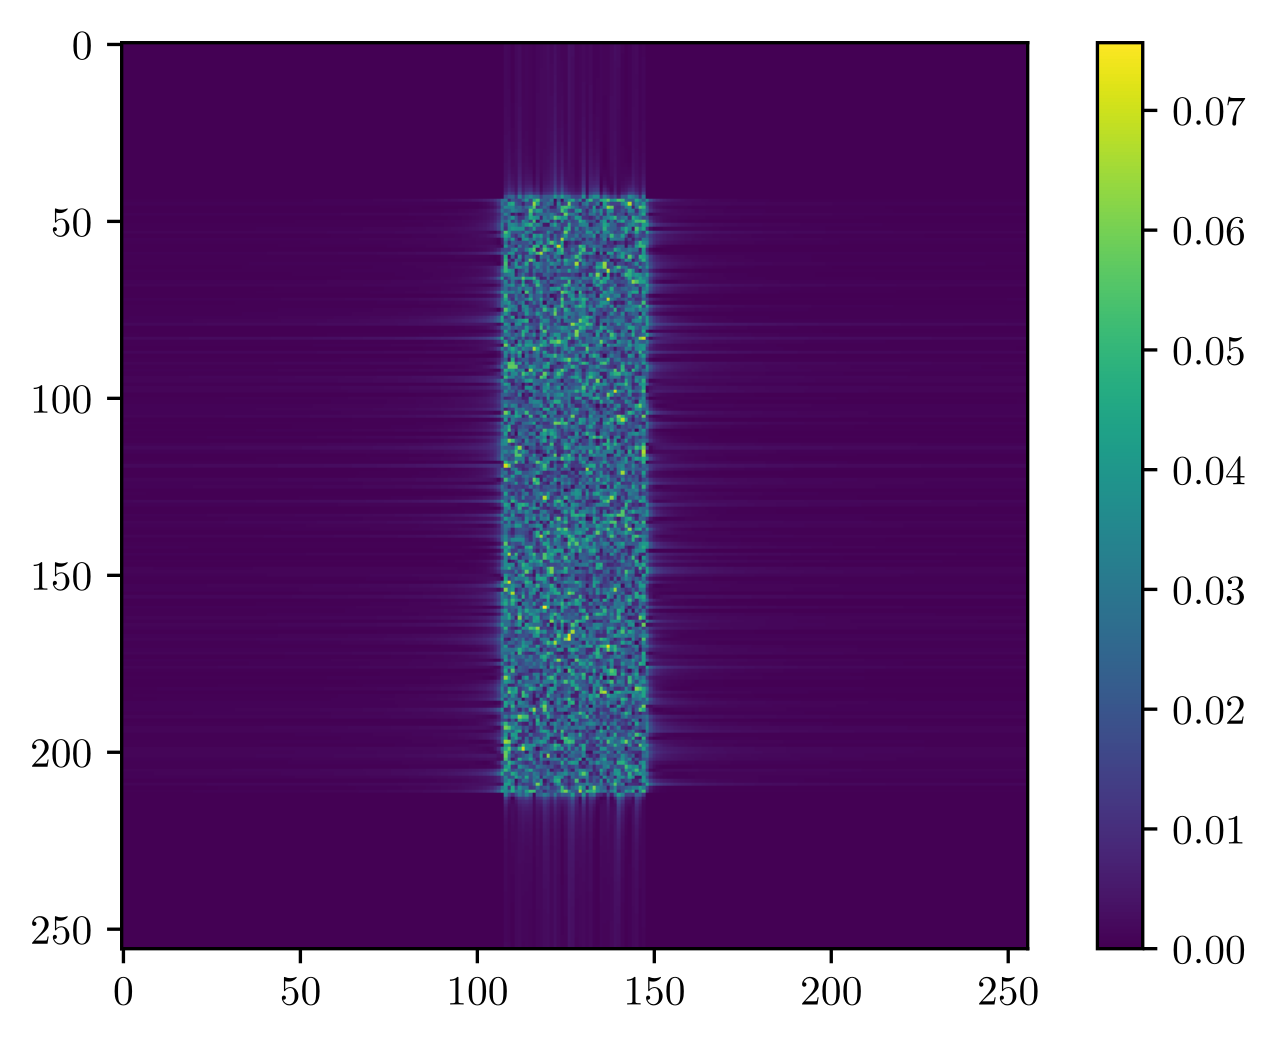

In [204]:
sos_func = get_sos(lens_params)
plt.imshow(tv_fun(sos_func))
plt.colorbar()

In [205]:
from jax.experimental import optimizers
from jax import jit
from tqdm import tqdm

losshistory = []

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(lens_params)

@jit
def update(opt_state, field):
    loss_and_field, gradient = jax.value_and_grad(loss, has_aux=True)(get_params(opt_state), field)
    return loss_and_field[0], loss_and_field[1], update_fun(k, gradient, opt_state)

pbar = tqdm(range(100))
field = -src_fourier_params
for k in pbar:
    lossval, field, opt_state = update(opt_state, field)
    # For logging
    pbar.set_description("Ampl: {:01.4f}".format(-lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Ampl: 0.1154: 100%|███████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


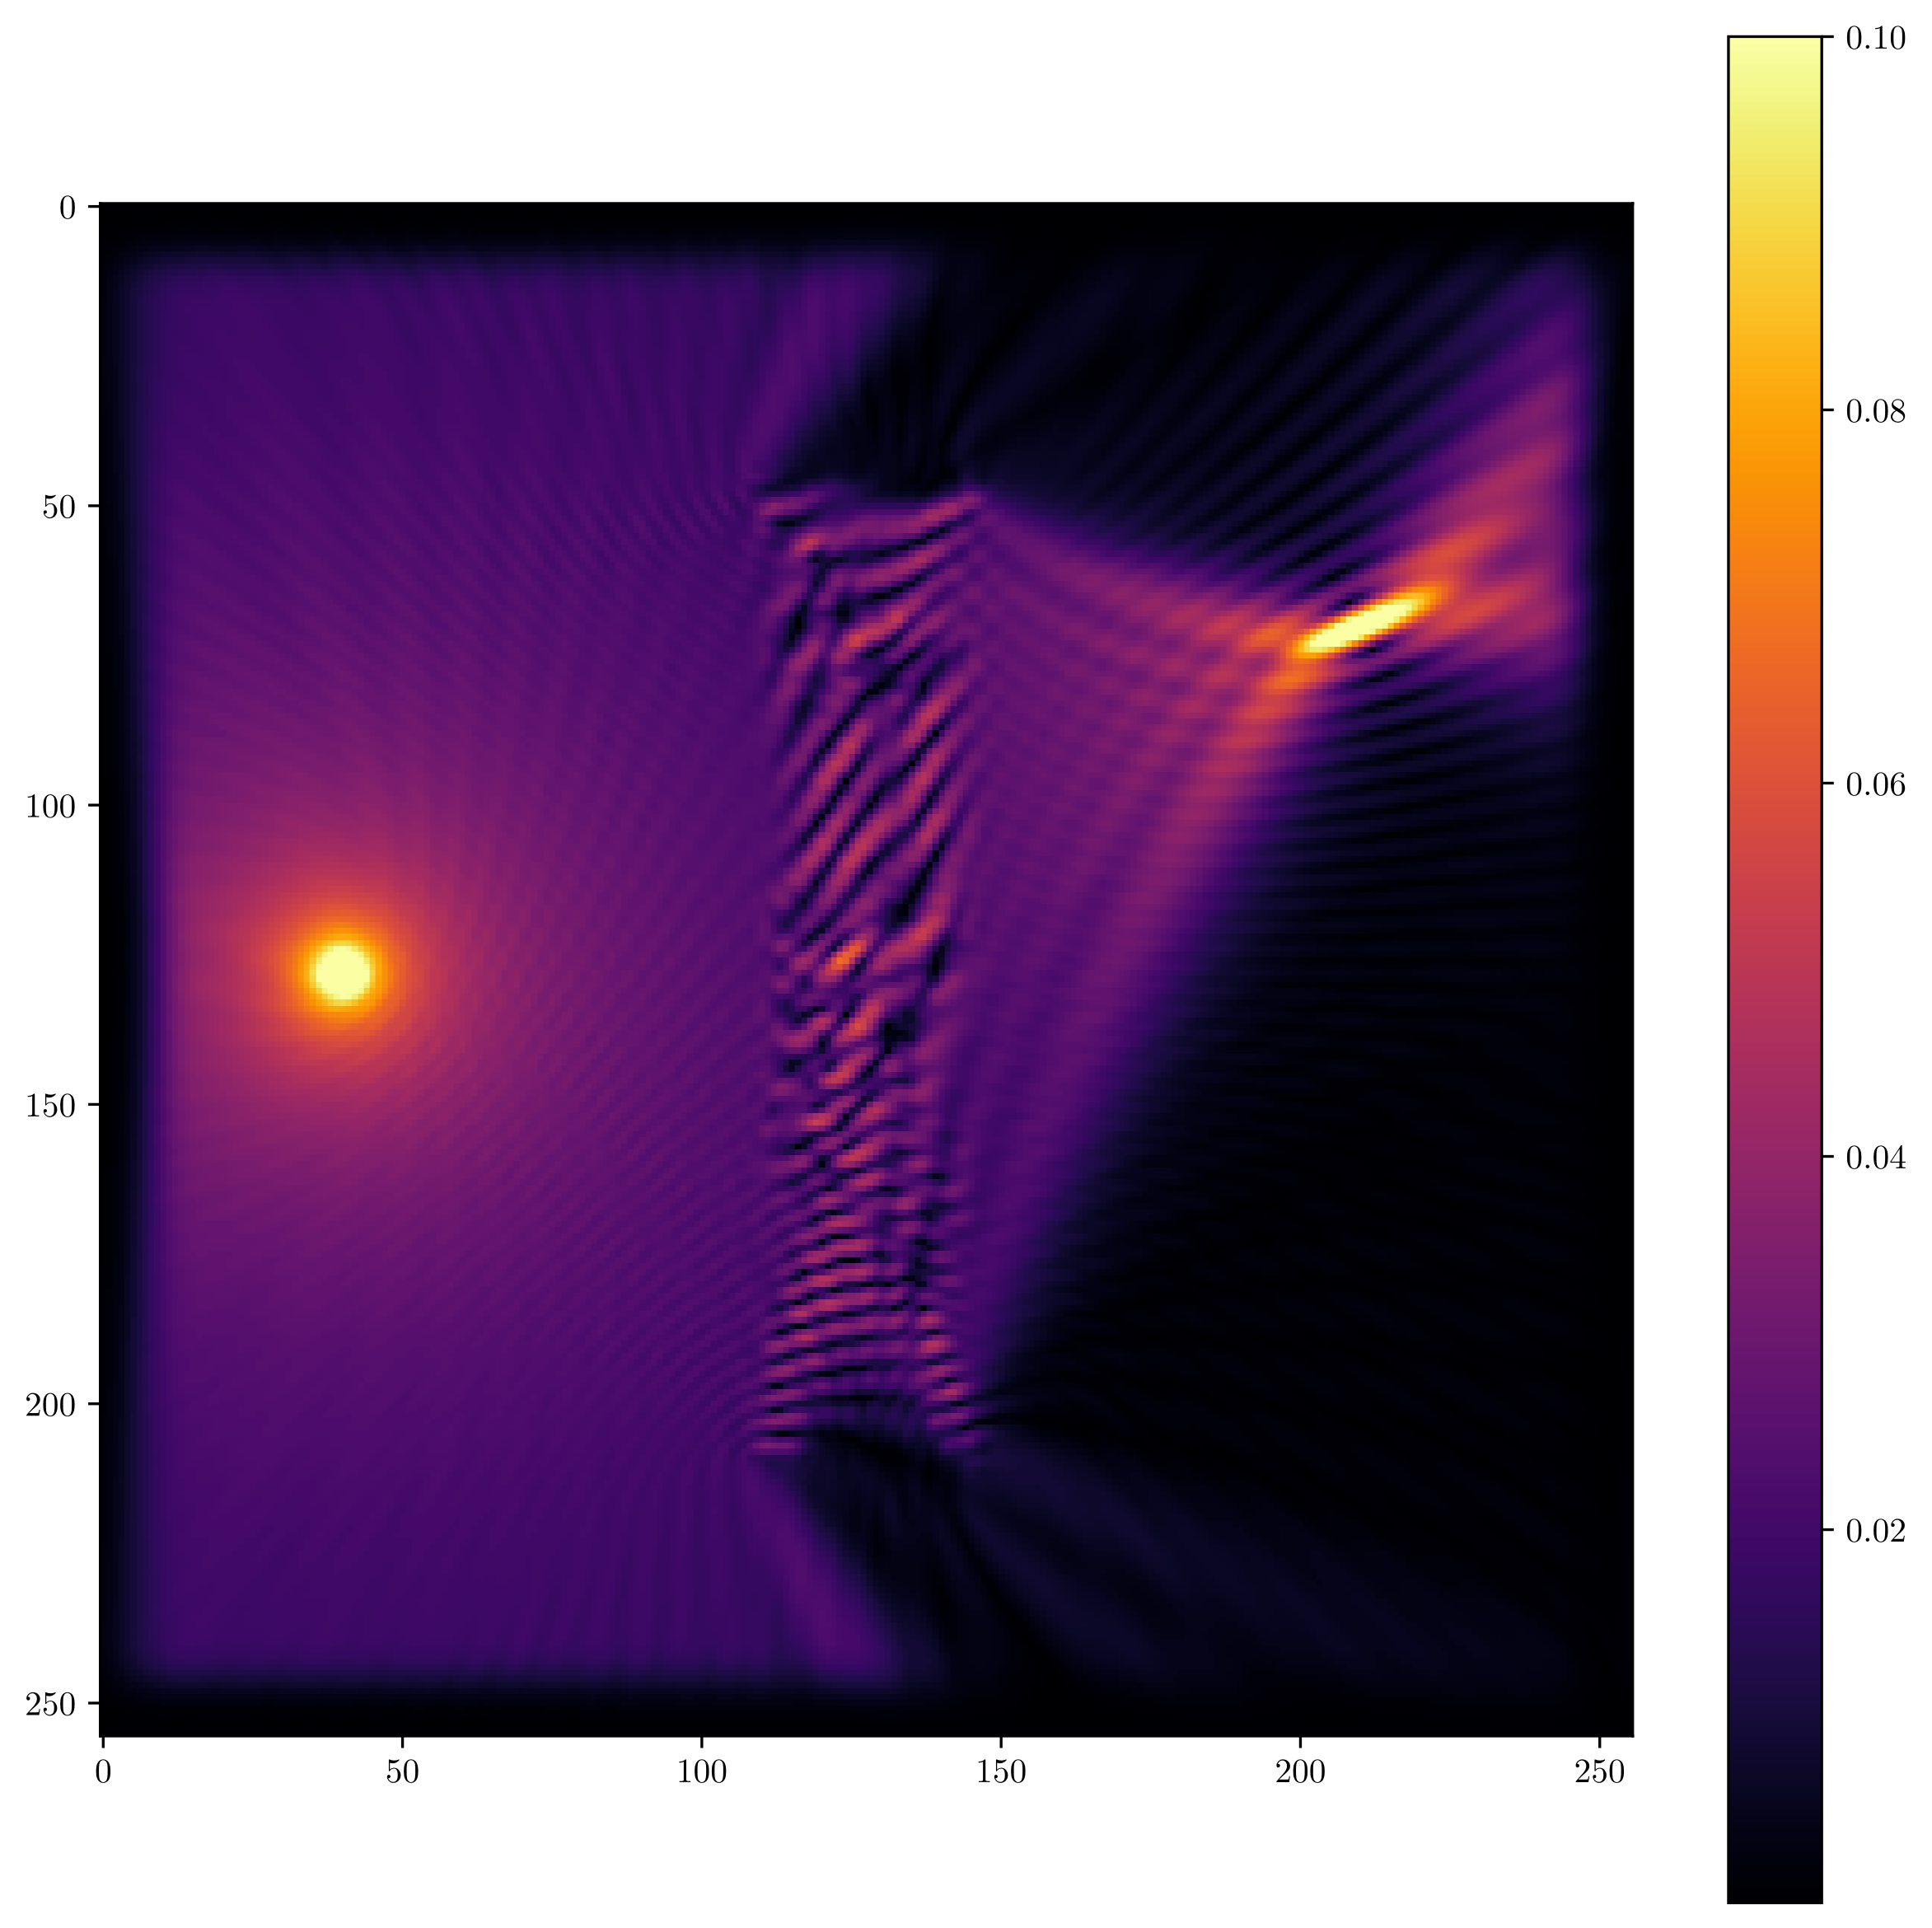

In [206]:
optimal_field = find_field(get_sos(get_params(opt_state)))
plt.figure(figsize=(10,10))
plt.imshow(jnp.abs(optimal_field), cmap="inferno", vmax=.1)
plt.colorbar()

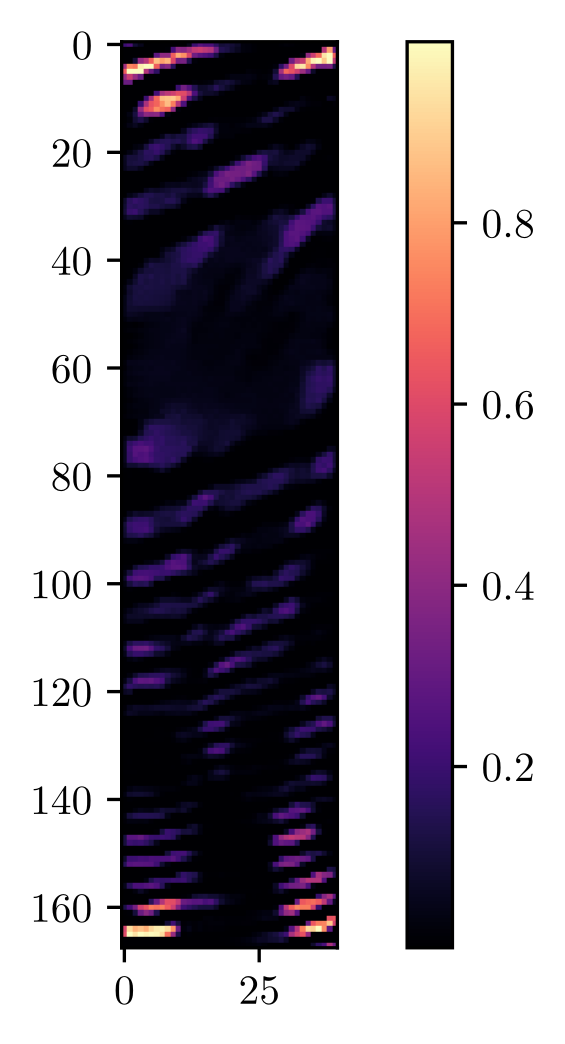

In [207]:
plt.imshow(jax.nn.sigmoid(get_params(opt_state)), cmap="magma")
plt.colorbar()

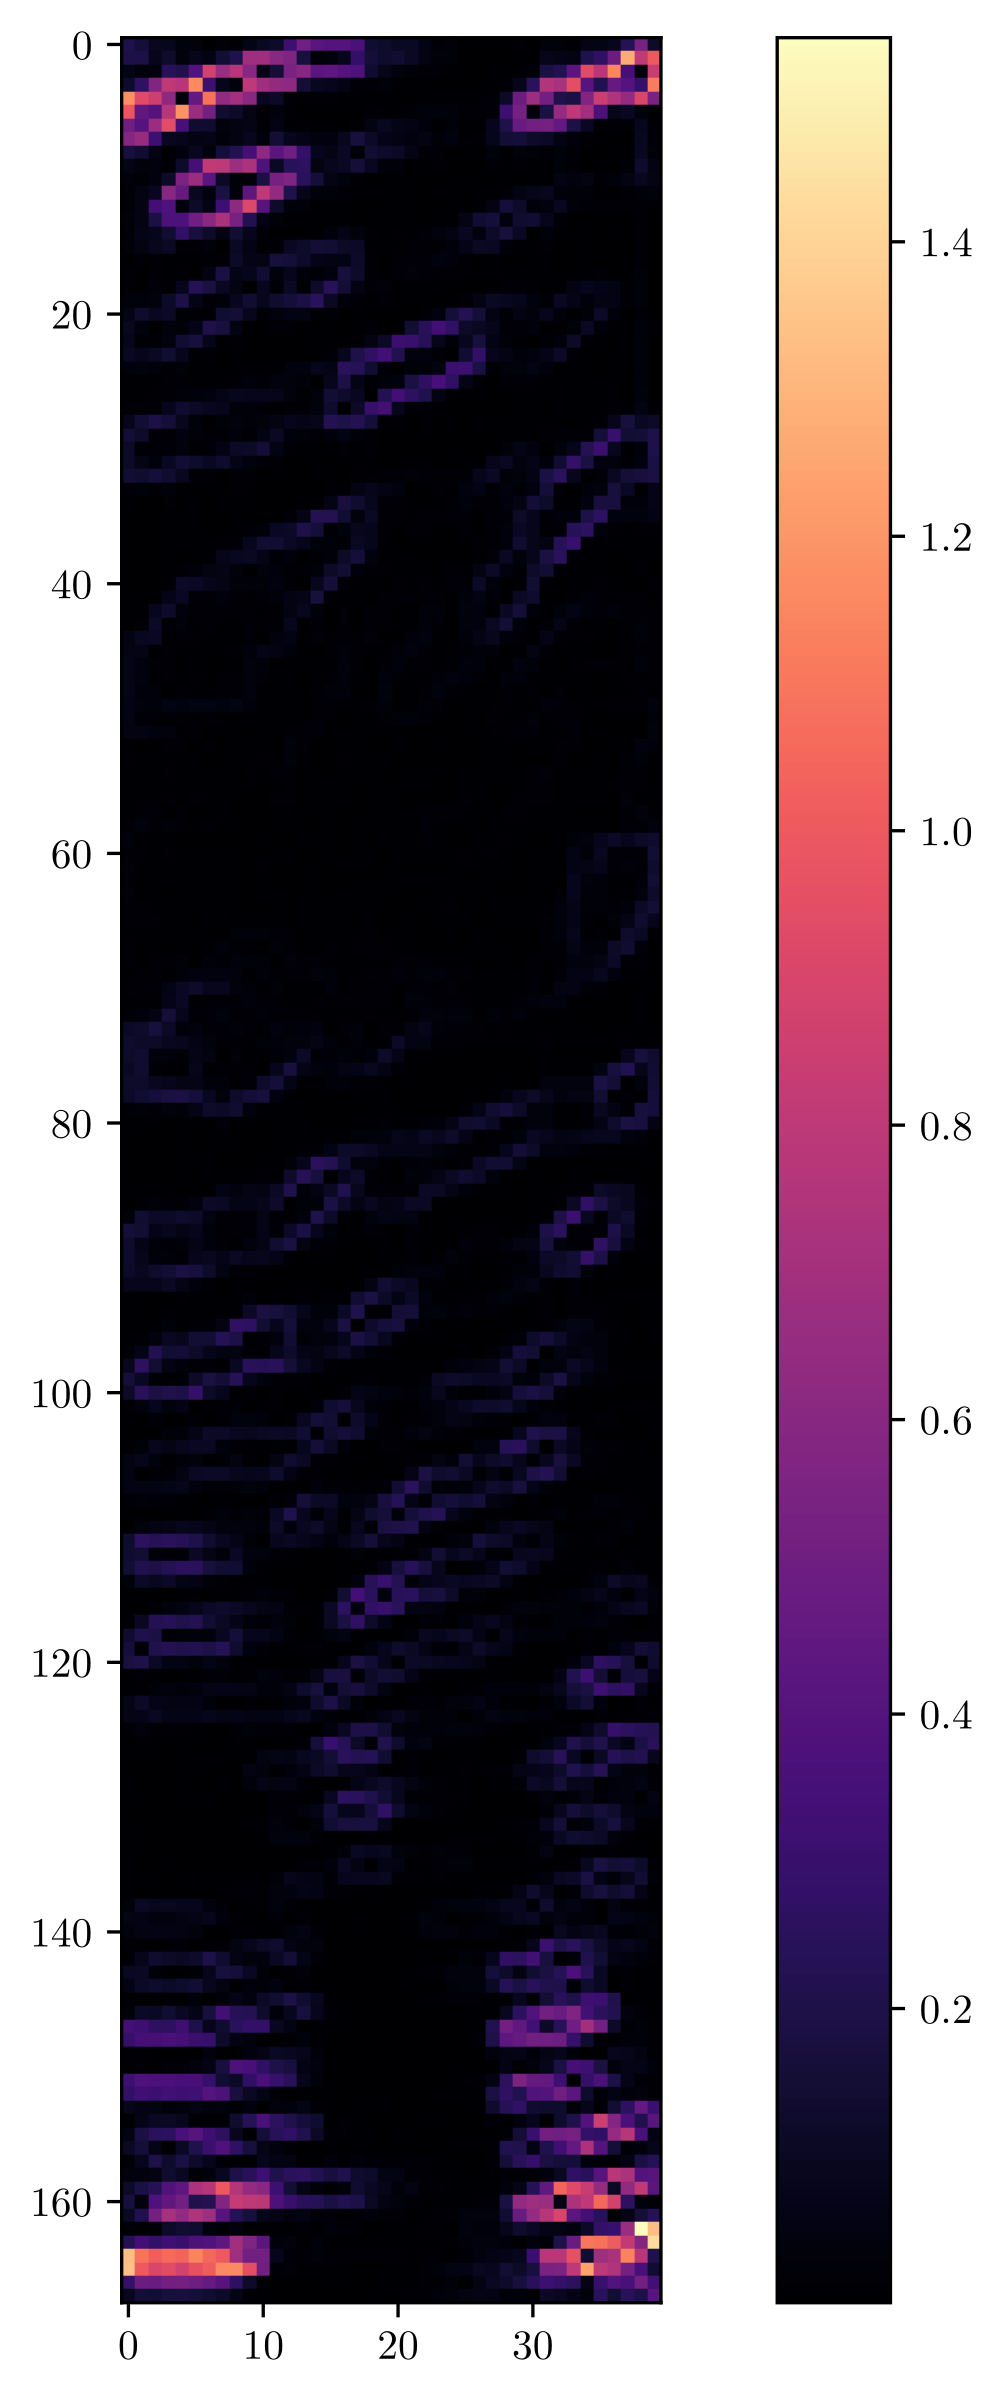

In [208]:
plt.figure(figsize=(10,10))
sos_func = get_sos(get_params(opt_state))
plt.imshow(tv_fun(sos_func)[44:212,108:148], cmap="magma")
plt.colorbar()

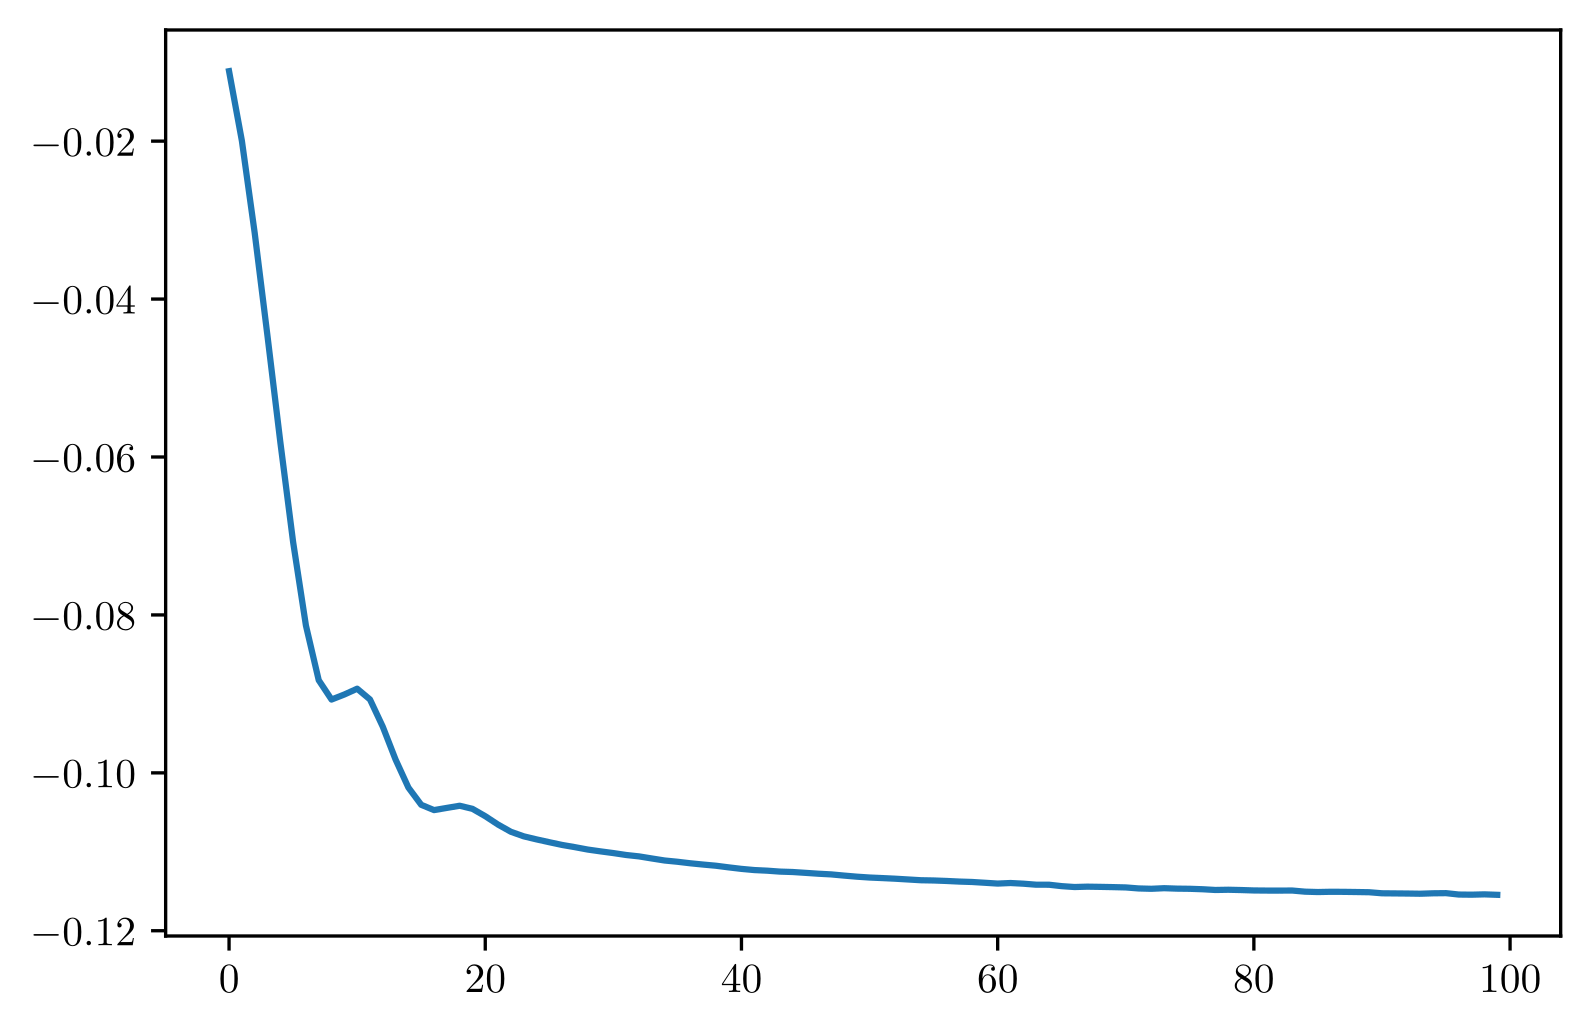

In [209]:
plt.plot(losshistory)

In [210]:
import matplotlib 

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
matplotlib.rcParams['figure.dpi'] = 300

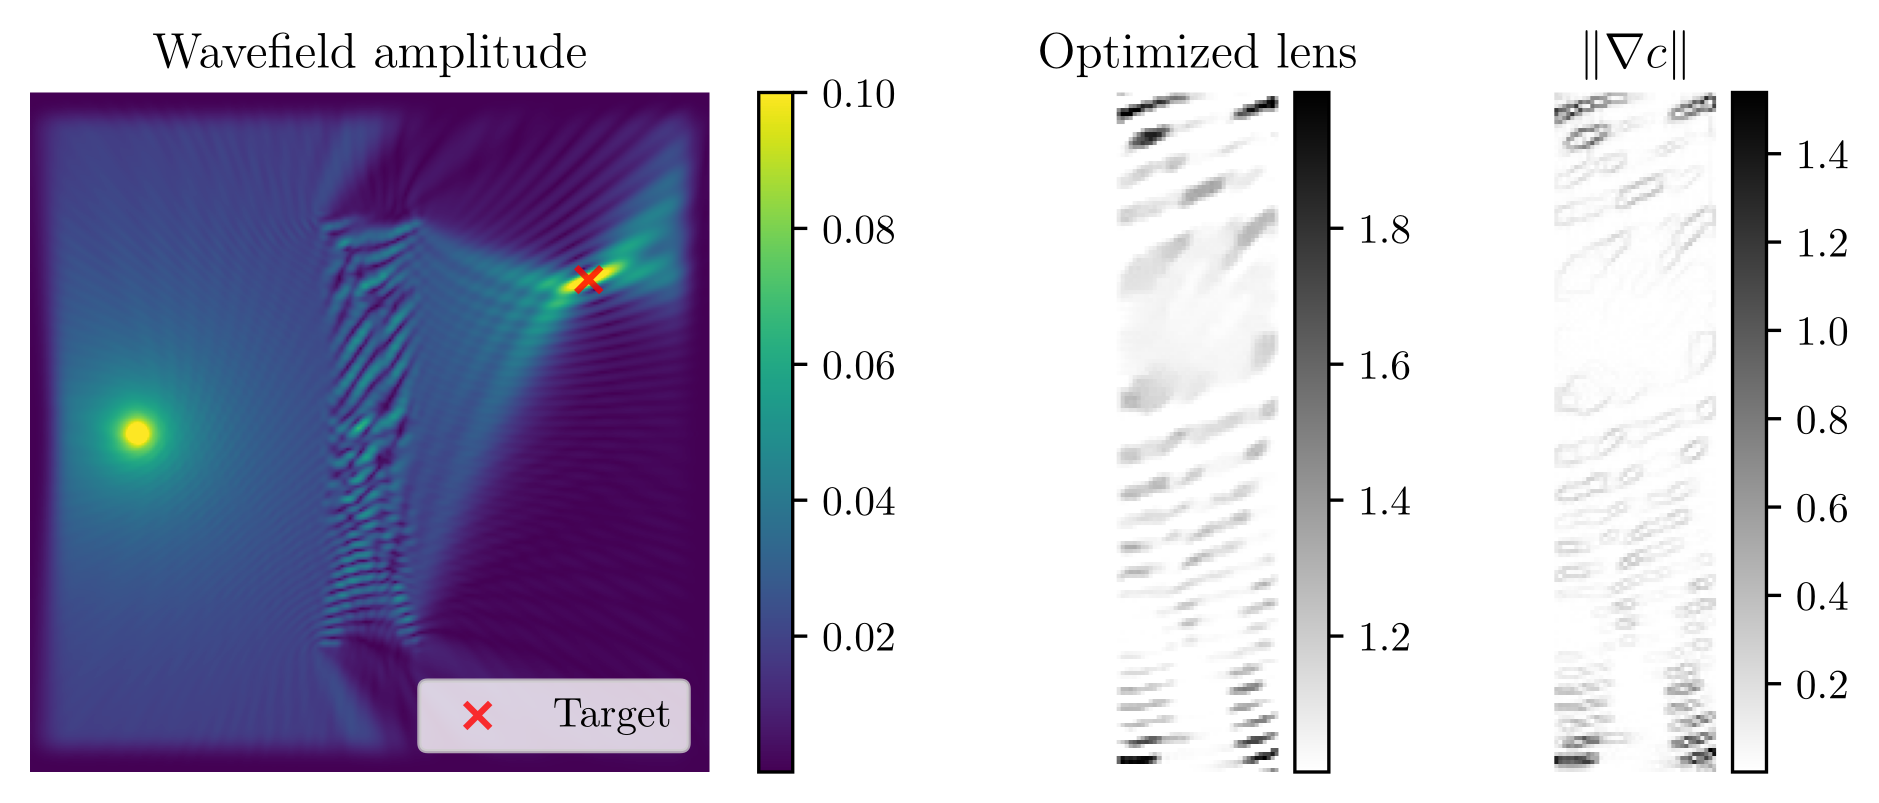

In [215]:
fig, ax = plt.subplots(1,3,figsize=(8,3), gridspec_kw={'width_ratios': [3, 1, 1]})

im1 = ax[0].imshow(jnp.abs(optimal_field), cmap="viridis", vmax=.1)
ax[0].axis("off")
ax[0].scatter(210,70, marker='x', color="red", label="Target", alpha=0.8)
plt.colorbar(im1, ax=ax[0])
ax[0].set_title("Wavefield amplitude")
ax[0].legend(loc="lower right")

sos_opt = get_sos(get_params(opt_state))
im2 = ax[1].imshow(sos_opt[44:212,108:148], cmap="binary")
plt.colorbar(im2, ax=ax[1])
ax[1].set_title("Optimized lens")
ax[1].axis("off")

im3 = ax[2].imshow(tv_fun(sos_opt)[44:212,108:148], cmap="binary")
plt.colorbar(im3, ax=ax[2])
ax[2].set_title("$\\|\\nabla c\\|$")
ax[2].axis("off")

plt.savefig('img/optimized_lens.pgf')

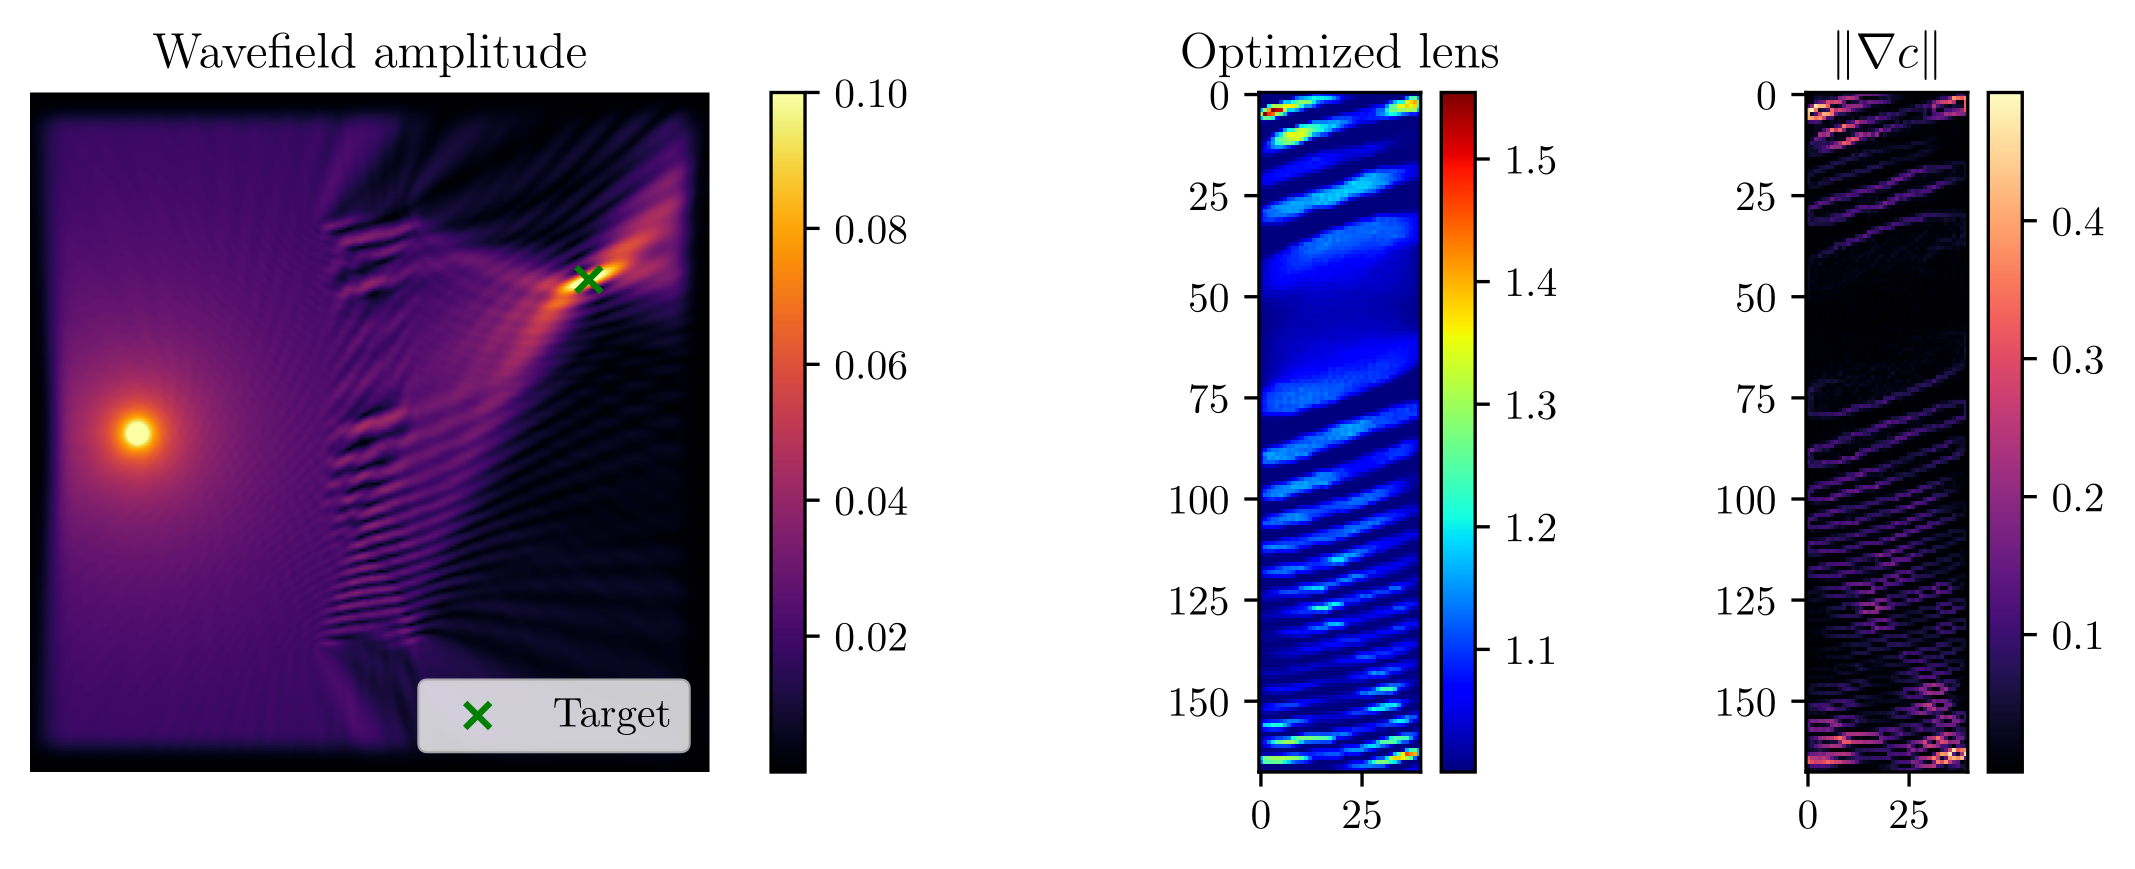

In [120]:
fig, ax = plt.subplots(1,3,figsize=(10,3), gridspec_kw={'width_ratios': [3, 1, 1]})

im1 = ax[0].imshow(jnp.abs(optimal_field), cmap="inferno", vmax=.1)
ax[0].axis("off")
ax[0].axis("off")
ax[0].scatter(210,70, marker='x', color="green", label="Target")
plt.colorbar(im1, ax=ax[0])
ax[0].set_title("Wavefield amplitude")
ax[0].legend(loc="lower right")

sos_opt = get_sos(get_params(opt_state))
im2 = ax[1].imshow(sos_opt[44:212,108:148], cmap="jet")
plt.colorbar(im2, ax=ax[1])
ax[1].set_title("Optimized lens")

im3 = ax[2].imshow(tv_fun(sos_opt)[44:212,108:148], cmap="magma")
plt.colorbar(im3, ax=ax[2])
ax[2].set_title("$\\|\\nabla c\\|$")

plt.savefig('img/optimized_lens.pgf')